In [1]:
import sys

from rdkit import Chem, rdBase
from rdkit.Chem import Draw

from razi.rdkit_postgresql.functions import atompairbv_fp

from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

from souyakuRB_tables import Compound, Library


print(sys.version_info)
print(f'RDKit version: {rdBase.rdkitVersion}')

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
RDKit version: 2018.03.4


In [2]:
engine = create_engine('postgresql://postgres@db:5432/souyakuRB2018')
Base = declarative_base(bind=engine)
Session = sessionmaker(bind=engine)

#### Test compound table

In [3]:
session = Session()
compounds = session.query(Compound)

In [4]:
compounds.count()

3053222

In [5]:
for compound in compounds.limit(10):
    print(f'{compound}')

(Z2754449885) < NCCSCCSCCN >
(Z1695906904) < Oc1c(Br)cc(F)nc1Br >
(Z57056341) < c1ccc(COc2ccccc2CNC2CCCC2)cc1 >
(Z1362646021) < Cc1c(CNCCNC(=O)OC(C)(C)C)cc(C#N)n1C >
(Z90122418) < CCCOc1ccc2ccccc2c1CNC >
(Z45537422) < COc1ccccc1S(=O)(=O)NC1CCCC1 >
(Z2446038844) < O=C(O)Cn1nnnc1CCc1ccccc1 >
(Z208334124) < Cc1cc(NC(=O)N2CCOCC2)ccc1Br >
(Z18356103) < Nc1nnc(SCc2coc(-c3cccs3)n2)[nH]1 >
(Z26397669) < O=C(NC1CCCc2ccccc21)c1ccco1 >


##### substructure search

In [6]:
query = 'c1cc(OCC)ccc1N2CCCC2=O'
sub_compounds = compounds.filter(Compound.structure.hassubstruct(query))
sub_compounds.count()

1650

In [7]:
sub_compounds = sub_compounds[:6]

In [8]:
highlight_atoms = [compound.structure.GetSubstructMatch(Chem.MolFromSmiles(query)) 
                                for compound in sub_compounds]

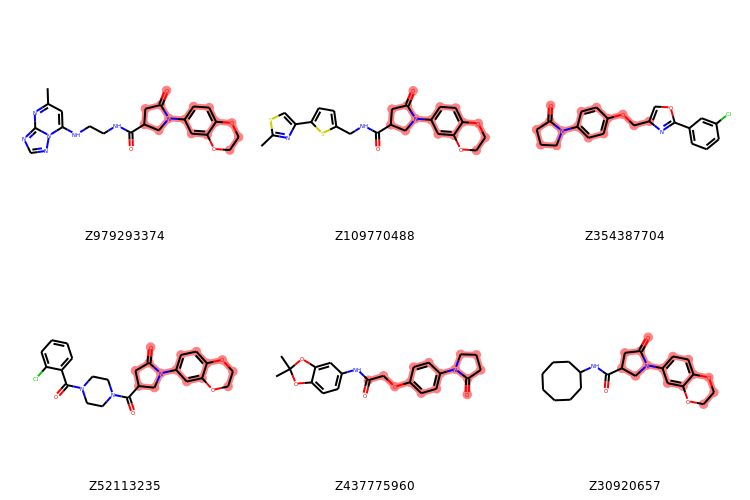

In [9]:
Draw.MolsToGridImage(
    [compound.structure for compound in sub_compounds], 
    legends=[compound.name for compound in sub_compounds],
    highlightAtomLists=highlight_atoms,
    subImgSize=(250, 250)
)

In [10]:
session.close()

##### similarity search

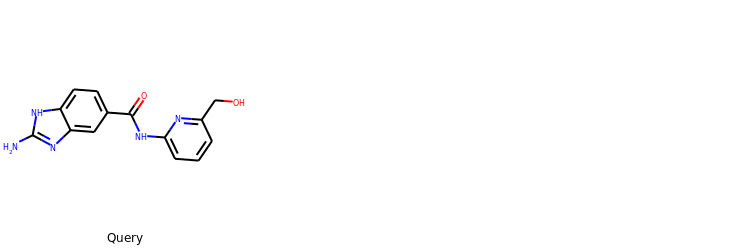

In [11]:
smiles = 'Nc1nc2cc(C(=O)Nc3cccc(CO)n3)ccc2[nH]1'
mol = Chem.MolFromSmiles(smiles)
Draw.MolsToGridImage([mol], subImgSize=(250, 250), legends=['Query'])

In [12]:
session.execute('set rdkit.tanimoto_threshold=0.6')

In [13]:
session.scalar('show rdkit.tanimoto_threshold')

'0.6'

In [14]:
fp = atompairbv_fp(smiles)

In [15]:
compounds = session.query(Compound)
sim_compounds = compounds.filter(Compound.atompair.tanimoto_sml(fp))
sim_compounds.count()

2

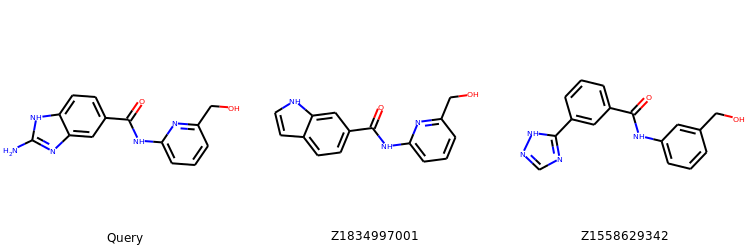

In [16]:
Draw.MolsToGridImage(
    [mol]+[compound.structure for compound in sim_compounds], 
    legends=['Query']+[compound.name for compound in sim_compounds],
    subImgSize=(250, 250)
)

In [17]:
session.close()

#### Test library table

In [18]:
session = Session()
libraries = session.query(Library)

In [19]:
libraries.count()

4

In [20]:
libraries.all()

[Enamine_Advanced_collection,
 Enamine_Premium_collection,
 Enamine_HTS_collection,
 UOS_HTS]

In [21]:
for library in libraries:
    print(f'{library.id}: {library.name}')

1: Enamine_Advanced_collection
2: Enamine_Premium_collection
3: Enamine_HTS_collection
4: UOS_HTS


In [22]:
session.close()

# EOF